### 因果推論周りの勉強のためのnotebook

岩波booksのサンプルデータを用いて, 因果推論の一連の流れを学ぶ

参考url: https://pira-nino.hatenablog.com/entry/causal_inference_implement

In [2]:
import lightgbm as lgb
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import log_loss, mean_squared_error, roc_auc_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_curve,auc
from sklearn.neighbors import NearestNeighbors


%matplotlib inline
# その他設定
pd.set_option('display.max_columns', 100)
plt.style.use('seaborn-darkgrid')
font = fm.FontProperties(fname='./TakaoPGothic.ttf')

dataset_url = 'https://raw.githubusercontent.com/' \
              + 'iwanami-datascience/vol3/master/kato%26hoshino/q_data_x.csv'  
df = pd.read_csv(dataset_url)  
print(df.shape)

(10000, 35)


In [3]:
# 列名のチェック. 項目に対して, ダミー編数化の処理がなされている
df.columns

Index(['cm_dummy', 'gamedummy', 'area_kanto', 'area_keihan', 'area_tokai',
       'area_keihanshin', 'age', 'sex', 'marry_dummy', 'job_dummy1',
       'job_dummy2', 'job_dummy3', 'job_dummy4', 'job_dummy5', 'job_dummy6',
       'job_dummy7', 'job_dummy8', 'inc', 'pmoney', 'fam_str_dummy1',
       'fam_str_dummy2', 'fam_str_dummy3', 'fam_str_dummy4', 'fam_str_dummy5',
       'child_dummy', 'T', 'F1', 'F2', 'F3', 'M1', 'M2', 'M3', 'TVwatch_day',
       'gamesecond', 'gamecount'],
      dtype='object')

In [4]:
df.head()

,cm_dummy,gamedummy,area_kanto,area_keihan,area_tokai,area_keihanshin,age,sex,marry_dummy,job_dummy1,job_dummy2,job_dummy3,job_dummy4,job_dummy5,job_dummy6,job_dummy7,job_dummy8,inc,pmoney,fam_str_dummy1,fam_str_dummy2,fam_str_dummy3,fam_str_dummy4,fam_str_dummy5,child_dummy,T,F1,F2,F3,M1,M2,M3,TVwatch_day,gamesecond,gamecount
0,0,0,0,0,0,1,44.5,1,1,1,0,0,0,0,0,0,0,249.5,0.0,0,0,1,0,0,1,0,0,0,0,0,1,0,33.427600,0,0
1,0,0,0,1,0,0,34.5,1,1,1,0,0,0,0,0,0,0,800.0,12.5,0,0,1,0,0,1,0,0,0,0,0,1,0,31.542862,0,0
2,0,0,0,1,0,0,24.5,1,0,0,0,0,0,0,0,1,0,0.0,2.0,0,0,0,1,0,0,0,0,0,0,1,0,0,37.825805,0,0
3,0,0,0,1,0,0,44.5,1,1,1,0,0,0,0,0,0,0,800.0,2.0,0,0,1,0,0,1,0,0,0,0,0,1,0,36.345911,0,0
4,0,0,0,1,0,0,34.5,1,1,1,0,0,0,0,0,0,0,749.5,4.0,0,0,1,0,0,1,0,0,0,0,1,0,0,49.344942,0,0


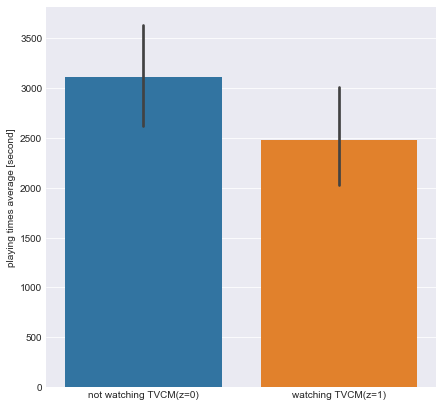

In [5]:
# 単純な集計を行うと, cmを見ていない人の方が, cmを見ている人よりもプレイ時間が長くなる.
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(1, 1, 1)
ax = sns.barplot(x='cm_dummy', y='gamesecond', data=df, ax=ax)
ax.set_xticklabels(['not watching TVCM(z=0)', 'watching TVCM(z=1)'])
ax.set_xlabel('')
ax.set_ylabel('playing times average [second]')
fig.show();

# matplotlibのRuntimeWarningがやかましいので消す
import warnings
warnings.simplefilter('ignore', RuntimeWarning)

In [6]:
z_col = 'cm_dummy'
x_cols = [
          col for col in df.columns
          if col not in ['gemecount', 'gamedummy', 'gamesecond', 'cm_dummy']
]

df_x = df[x_cols]
df_z = df[z_col]

In [11]:
test_ratio = 0.2
oof_preds_lgb = np.zeros(df.shape[0])
oof_preds_lr = np.zeros(df.shape[0])
oof_preds_rf = np.zeros(df.shape[0])
insample_logloss_list_lgb = []
insample_logloss_list_lr = []
insample_logloss_list_rf = []
feature_importance_df = pd.DataFrame()

kf = KFold(n_splits=5, shuffle=True, random_state=0)
for n_fold, (train_index, valid_index) in enumerate(kf.split(df_x)):
    print('CV_{}'.format(n_fold))
    X_train, z_train = df_x.values[train_index], df_z.values[train_index]
    X_test, z_test = df_x.values[valid_index], df_z.values[valid_index]

    # train -> TRAIN / VALに分割
    num_test = int(len(X_train) * test_ratio)
    index_all = np.random.choice(len(X_train),  len(X_train), replace=False)
    index_VAL = index_all[0:num_test]
    index_TRAIN = index_all[num_test:len(X_train)]
    X_TRAIN, z_TRAIN = X_train[index_TRAIN], z_train[index_TRAIN]
    X_VAL, z_VAL = X_train[index_VAL], z_train[index_VAL]
    lgb_train = lgb.Dataset(X_TRAIN, label=z_TRAIN, free_raw_data=False)
    lgb_val = lgb.Dataset(X_VAL, label=z_VAL, free_raw_data=False)

    # LightGBM
    print('LightGBM_fitting...')
    params = {
        'task': 'train',
        'objective': 'binary',
        'metric': 'binary',
    }
    model_lgb = lgb.train(
        params,
        lgb_train,
        valid_sets=[lgb_train, lgb_val],
        valid_names=['train', 'val'],
        num_boost_round=100000,
        early_stopping_rounds=100,
        verbose_eval=1000)
    # LogisticRegression
    print('LogisticRegression_fitting...')
    model_lr = LogisticRegression()
    model_lr.fit(X_train, z_train)

    #RF
    print('RandomForestClassifier_fitting...')
    model_rf =  RandomForestClassifier(n_estimators=500)
    model_rf.fit(X_train, z_train)
    
    # pred_for_insample
    # NOTE: 正確にはLightGBMではTrain ->(TRAIN., VAL)に分割している
    pred_insample_lgb = model_lgb.predict(X_train, num_iteration=model_lgb.best_iteration)
    pred_insample_lr =   model_lr.predict_proba(X_train)[:, 1]
    pred_insample_rf =   model_rf.predict_proba(X_train)[:, 1]
    insample_logloss_lgb = (log_loss(z_train, pred_insample_lgb))
    insample_logloss_lr = (log_loss(z_train, pred_insample_lr))
    insample_logloss_rf = (log_loss(z_train, pred_insample_rf))
    print('insample_logloss_of_LightGBM:{}'.format(insample_logloss_lgb))
    print('insample_logloss_of_LogisticRegression:{}'.format(insample_logloss_lr))
    print('insample_logloss_of_RandomForestClassifier:{}'.format(insample_logloss_rf))
    insample_logloss_list_lgb.append(insample_logloss_lgb)
    insample_logloss_list_lr.append(insample_logloss_lr)
    insample_logloss_list_rf.append(insample_logloss_rf)

    # pred_for_oof
    oof_pred_lgb = model_lgb.predict(X_test, num_iteration=model_lgb.best_iteration)
    oof_pred_lr = model_lr.predict_proba(X_test)[:, 1]
    oof_pred_rf = model_rf.predict_proba(X_test)[:, 1]
    
    oof_preds_lgb[valid_index] = oof_pred_lgb
    oof_preds_lr[valid_index] = oof_pred_lr
    oof_preds_rf[valid_index] = oof_pred_rf

    oof_logloss_lgb = (log_loss(z_test, oof_pred_lgb))
    oof_logloss_lr = (log_loss(z_test, oof_pred_lr))
    oof_logloss_rf = (log_loss(z_test,oof_pred_rf))
    print('oof_logloss_of_LightGBM:{}'.format(oof_logloss_lgb))
    print('oof_logloss_of_LogisticRegression:{}'.format(oof_logloss_lr))
    print('oof_logloss_of_RandomForestClassifier:{}'.format(oof_logloss_rf))


    # 重要度の算出
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = x_cols
    fold_importance_df["importance"] = np.log1p(
        model_lgb.feature_importance(
        importance_type='gain', iteration=model_lgb.best_iteration))
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat(
        [feature_importance_df, fold_importance_df], axis=0)

print('all_CV_done')
print('CV_insample_logloss_of_LightGBM:{}'.format(np.mean(insample_logloss_list_lgb)))
print('CV_insample_logloss_of_LogisticRegression:{}'.format(np.mean(insample_logloss_list_lr)))
print('CV_insample_logloss_of_RandomForestClassifier:{}'.format(np.mean(insample_logloss_list_rf)))
print('CV_oof_logloss_of_LightGBM:{}'.format(log_loss(df_z, oof_preds_lgb)))
print('CV_oof_logloss_of_LogisticRegression:{}'.format(log_loss(df_z, oof_preds_lr)))
print('CV_oof_logloss_of_RandomForestClassifier:{}'.format(log_loss(df_z, oof_preds_rf)))

# #予測値をdfに追加
df['pred_lgb'] = oof_preds_lgb
df['pred_lr'] = oof_preds_lr
df['pred_rf'] = oof_preds_rf

CV_0
LightGBM_fitting...
Training until validation scores don't improve for 100 rounds
[1000]	train's binary_logloss: 0.000719272	val's binary_logloss: 0.000533337
Early stopping, best iteration is:
[1449]	train's binary_logloss: 0.000460715	val's binary_logloss: 7.97493e-05
LogisticRegression_fitting...
RandomForestClassifier_fitting...
insample_logloss_of_LightGBM:0.00038452173000028556
insample_logloss_of_LogisticRegression:0.5504965325974166
insample_logloss_of_RandomForestClassifier:0.001775882127651396
oof_logloss_of_LightGBM:0.0001963280888477414
oof_logloss_of_LogisticRegression:0.549571109576238
oof_logloss_of_RandomForestClassifier:0.004513478769208076
CV_1
LightGBM_fitting...
Training until validation scores don't improve for 100 rounds
[1000]	train's binary_logloss: 0.00228226	val's binary_logloss: 0.00353027
Early stopping, best iteration is:
[1063]	train's binary_logloss: 0.00217041	val's binary_logloss: 0.00336798
LogisticRegression_fitting...
RandomForestClassifier_fitt

In [14]:
df[['pred_lgb', 'pred_lr', 'pred_rf']]

,pred_lgb,pred_lr,pred_rf
0,4.946575e-09,0.057115,0.000
1,5.251263e-11,0.279454,0.002
2,1.727868e-05,0.355944,0.002
3,1.153961e-09,0.182979,0.000
4,6.397047e-09,0.217770,0.000
...,...,...,...
9995,7.833143e-07,0.190772,0.000
9996,8.385474e-06,0.157096,0.000
9997,2.933753e-06,0.117688,0.000
9998,2.192861e-06,0.323965,0.000


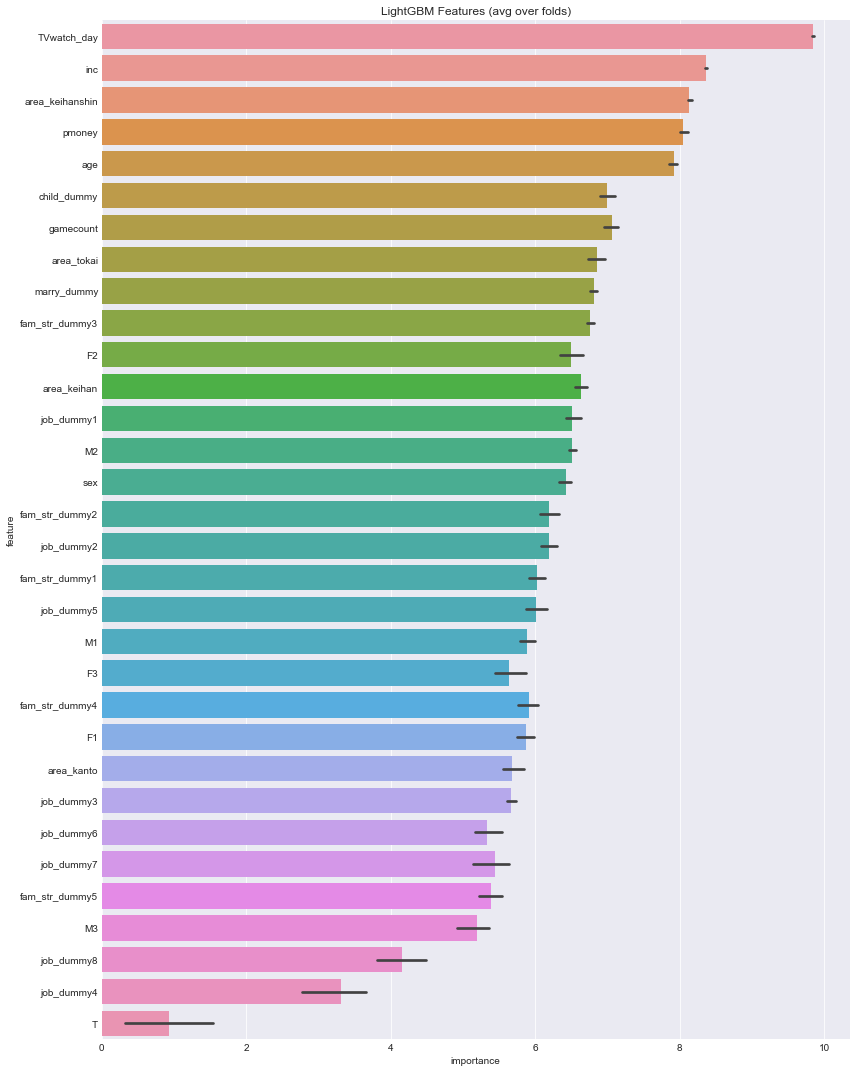

In [15]:
def display_importances(feature_importance_df_, png_path=None):
    cols = feature_importance_df_[[
        "feature", "importance"
    ]].groupby("feature").mean().sort_values(
        by="importance", ascending=False)[:100].index

    best_features = feature_importance_df_.loc[
        feature_importance_df_.feature.isin(cols)]

    plt.figure(figsize=(12, 15))

    sns.barplot(
        x="importance",
        y="feature",
        data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    if png_path is not None:
        plt.savefig(png_path)

display_importances(feature_importance_df)

model:lgb_auc:0.999999
model:lr_auc:0.760330
model:rf_auc:1.000000


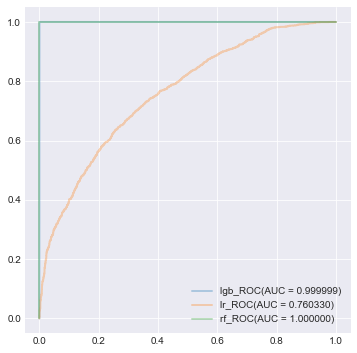

In [16]:
fig = plt.figure(figsize=[6, 6])
ax = fig.add_subplot(111,aspect = 'equal')
for model in ['lgb', 'lr', 'rf']:
    prob = df['pred_{}'.format(model)]
    fpr, tpr, t = roc_curve(df['cm_dummy'], prob)
    roc_auc = auc(fpr, tpr)
    print('model:{}_auc:{:.6f}'.format(model, roc_auc))
    ax.plot(fpr, tpr, lw=2, alpha=0.3, label='{}_ROC(AUC = {:.6f})'.format(model, roc_auc))
ax.legend(prop={'size': 10})
fig.show()

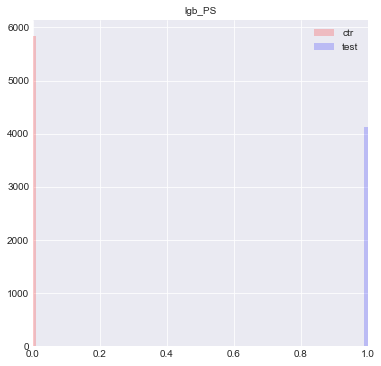

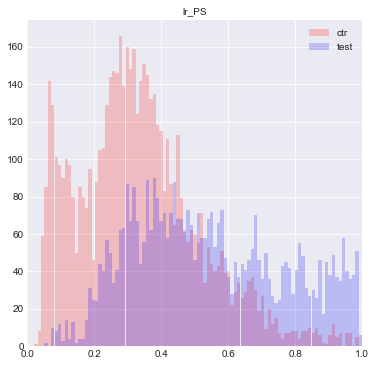

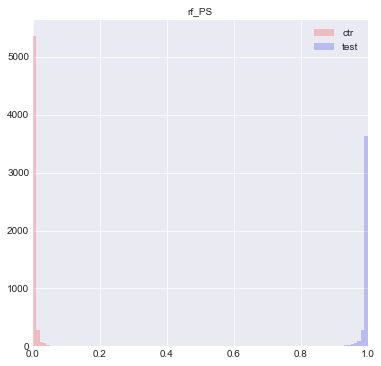

In [18]:
def visualize_ps(model, png_path=None):
    fig = plt.figure(figsize=[6, 6])
    ax = fig.add_subplot(111)
    bins = np.linspace(0, 1, 100)
    ax.hist(
        df[df['cm_dummy'] == 0]['pred_{}'.format(model)],
        bins=bins,
        color='red',
        width=0.01,
        alpha=0.2,
        label='ctr')
    ax.hist(
        df[df['cm_dummy'] == 1]['pred_{}'.format(model)],
        bins=bins,
        color='blue',
        width=0.01,
        alpha=0.2,
        label='test')
    ax.set_xlim(0, 1.0)
    ax.legend(prop={'size': 10})
    ax.set_title('{}_PS'.format(model), fontdict={'fontsize': 10})
    fig.show()
    if png_path is not None:
        fig.savefig(png_path)


for model in ['lgb', 'lr', 'rf']:
    visualize_ps(model)

In [ ]:
col = 'TVwatch_day'
model = 'lr'
z_col = 'cm_dummy'
ps_col = 'pred_{}'.format(model)

df_test = df.loc[df[z_col] == 1][[col, ps_col]]
df_ctr = df.loc[df[z_col] == 0][[col, ps_col]]